# Homework 2
**Instructions:**
- Submit your code to github by the deadline.
- DO NOT change paths (-3 points).
- DO NOT submit data to github (-2 points).

In [1]:
import numpy as np
import pandas as pd

## Problem 1: log loss
**(a)** You have a classification problem with 3 classes: "cat", "dog", "bird". For your test observation is a "dog". Your model give you the following prediction for that observation (0.1, 0.5, 0.4). What is the accuracy? What is the log loss?

**(b)** Suppose that you are submitting to a Kaggle competition. You are solving a binary classification task being evaluated by log loss metric. You suspect train and test target distributions are different, you submit a constant predition of 0.3 and to the public LB and get a score of 1.01. Mean of target variable in train is 0.44. What is the mean of target variable in public part of test data? Explain how you derive the results.

**(c)** You have a set of images that are tagged with labels. Each image may be tagged with more than one label. You have a total of 4 labels. Here is the soft prediction for one of your test images (0.1, 0.9, 0.8, 0.3). What is the hard prediction if you are using a threshold of 0.7? What is the loss if your real label is (0, 1, 0, 0)?

In [2]:
# YOUR CODE HERE
# (a)
obs = [0, 1, 0]
pred = [0.1, 0.5, 0.4]
tup = []
for i in range(len(obs)):
    tup.append((obs[i], pred[i]))

if pred.index(max(pred)) == obs.index(1):
    print('The accuracy is 1')
else:
    print('The accuracy is 0')

logloss = -sum([pair[0]*np.log(pair[1]) for pair in tup])
print('The log loss is %.3f'%logloss)

The accuracy is 1
The log loss is 0.693


YOUR ANSWER HERE

(b)

$LogLoss = - \frac{1}{N} \sum\limits^N_{i=1}[y_i \cdot log(\hat{y_i}) + (1-y_i) \cdot log(1-\hat{y_i}) ]$

$1.01= - \frac{1}{N} \sum\limits^N_{i=1}[y_i \cdot log(0.3) + (1-y_i) \cdot log(1-0.3) ]$

Supporse the number of 0 is $N_0$ and the number of 1 is $N_1$

$1.01= - \frac{N_1 log0.3 + N_0 log0.7}{N_1 + N_0}$

$ N_0 = - \frac{log0.3+1.01}{log0.7+1.01}N_1$

$ N_0+N_1 = \frac{log0.7-log0.3}{log0.7+1.01}N_1$

$\bar{y} = \frac{N1}{N_1 + N_0} = \frac{log0.7+1.01}{log0.7-log0.3} = 0.77 $

In [3]:
# YOUR CODE HERE
# (c)
obs = [0, 1, 0, 0]
pred = [0.1, 0.9, 0.8, 0.3]
tup = []
for i in range(len(obs)):
    tup.append((obs[i], pred[i]))

logloss = -sum([pair[0]*np.log(pair[1])+(1-pair[0])*np.log(1-pair[1]) for pair in tup])
print('The soft prediction log loss is %.3f'%logloss)

The soft prediction log loss is 2.177


YOUR ANSWER HERE

If we use a threshold of 0.7, the hard prediction is [0, 1, 1, 0]

## Problem 2: AUC
Compute AUC score by hand with the formula explained in class for the following dataset.

In [4]:
d = pd.DataFrame({
        'prediction': [0.1, 0.5, 0.95, 0.99, 0.8, 0.4, 0.03, 0.44, 0.2],
        'y': [1, 0, 1, 1, 1, 1, 0, 0, 0]})
d

,prediction,y
0,0.10,1
1,0.50,0
2,0.95,1
3,0.99,1
4,0.80,1
5,0.40,1
6,0.03,0
7,0.44,0
8,0.20,0


AUC is the probability a randomly-chosen positive example is ranked more highly than a randomly-chosen negative example. It can be computed as the ratio of

$$1 - \frac{\text{number of pairs example wrongly ordered }}{\text{number of pairs (positive, negative)}}$$

In [5]:
# YOUR CODE HERE
d = d.sort_values(['prediction']).reset_index().drop(['index'],axis=1)
pair_num = len(d[d['y']==0])*len(d[d['y']==1])
w_num = 0
for i in range(len(d['y'])):
    if d['y'][i] == 1:
        for j in range(i, len(d['y'])):
            if d['y'][j] == 0:
                w_num += 1
    
auc = 1-w_num/pair_num
print('The auc is %.3f' %auc)

The auc is 0.750


## Problem 3: Regularized mean (target) encoding for Avazu competition

For this problem you will implement a version of regularized mean encoding. We will be using the data on this Kaggle [compettion](https://www.kaggle.com/c/avazu-ctr-prediction).  

**Instructions:**
- Split data (training) into training and validation. Take the last week (7 days) of training set as validation.
- Implement regularized mean encoding for the training set using pandas.
- Implement mean encoding for the validation set

In [6]:
## Split train and validation 
# get sample data first
path = "avazu/"
!head -100000 $path/train > $path/train_sample.csv
!head -100000 $path/test > $path/test_sample.csv
data = pd.read_csv(path + "train_sample.csv")
test = pd.read_csv(path + "test_sample.csv")

In [7]:
def split_based_hour(data):
    """ Split data based on column hour.
    
    Use 20% of the date for validation.
    Inputs:
       data: dataframe from avazu
    Returns:
       train:
       val: 20% of the largest values of column "hour".
    """
    N = int(0.8*len(data))
    data = data.sort_values(by="hour")
    train = data[:N].copy()
    val = data[N:].copy()
    return train.reset_index(), val.reset_index()
train, val = split_based_hour(data)

### Regularized mean encoding 
Here is how you do mean encoding without regularization.

In [8]:
# Calculate a mapping: {device_type: click_mean}
mean_device_type = train.groupby('device_type').click.mean()
mean_device_type

device_type
0    0.224277
1    0.176116
4    0.069777
5    0.083333
Name: click, dtype: float64

In [9]:
# This is the global click mean
global_mean = train.click.mean()
global_mean

0.17477718471480894

In [10]:
train["device_type_mean_enc"] = train["device_type"].map(mean_device_type)
val["device_type_mean_enc"] = val["device_type"].map(mean_device_type)

In [11]:
train["device_type_mean_enc"].fillna(global_mean, inplace=True)
val["device_type_mean_enc"].fillna(global_mean, inplace=True)

In [12]:
# Print correlation
encoded_feature = val["device_type_mean_enc"].values
print(np.corrcoef(val["click"].values, encoded_feature)[0][1])

0.0530389229998215


To do mean encoding with K-fold regularization you do the following:

* Run a 5-fold split on train data where `mean_device_type` is computed on 4/5 of the data and the encoding is computed on the other 1/5.
* To compute mean encoding on the validation data use the code similar to encoding without regularization. That is compute on all the training data and apply to the validation set.

In [13]:
from sklearn.model_selection import KFold

def reg_target_encoding(train, col = "device_type", splits=5):
    """ Computes regularize mean encoding.
    Inputs:
       train: training dataframe
       
    """
    # YOUR CODE HERE
    kf = KFold(n_splits=splits)
    # train.drop('device_type_mean_enc', axis=1, inplace=True)
    i = 0
    new_col = col+'_mean_enc'
    for tra_index, val_index in kf.split(train):
        mean_device_type = train.loc[tra_index].groupby(col).click.mean()
        global_mean = train.loc[tra_index].click.mean()
        val = train.loc[val_index].copy()
        val[new_col] = val[col].map(mean_device_type)
        val[new_col].fillna(global_mean, inplace=True)
        if i == 0:
            new_train = val
        else:
            new_train = new_train.append(val)
        i += 1
    train[new_col] = new_train[new_col]

In [14]:
reg_target_encoding(train) 
encoded_feature = train["device_type_mean_enc"].values
corr = np.corrcoef(train["click"].values, encoded_feature)[0][1]
assert(np.around(corr, decimals=4) == 0.0551)

In [15]:
def mean_encoding_test(test, train, col = "device_type"):
    """ Computes target enconding for test data.
    
    This is similar to how we do validation
    """
    # YOUR CODE HERE
    mean_device_type = train.groupby(col).click.mean()
    global_mean = train.click.mean()
    new_col = col+'_mean_enc'
    train[new_col] = train[col].map(mean_device_type)
    train[new_col].fillna(global_mean, inplace=True)
    test[new_col] = test[col].map(mean_device_type)
    test[new_col].fillna(global_mean, inplace=True)

In [16]:
mean_encoding_test(test, train) 
encoded_feature_mean = test["device_type_mean_enc"].values.mean()
assert(np.around(encoded_feature_mean, decimals=4) == 0.177)

## Problem 4: Implement other features and fit a model (10 points)
* Implement a few more features, include:
   * day of the week and hour
   * mean encoding of some other features (at least two)
   * use plots and `value_counts()` to understand the data

* Fit a random forest (to the whole dataset)
   * Do hyperparameter tunning using your validation set
   * Report test and train log loss

In [17]:
def load_data():
    path = "avazu/"
    data = pd.read_csv(path + "train")
    test = pd.read_csv(path + "test")
    return data, test

## 4.0 Load Data

In [18]:
path = "avazu/"
type1 = {'id': np.uint32, 'click': np.uint8, 'hour': np.uint32, 'C1': np.uint32, 'banner_pos': np.uint32,
         'site_id': 'category', 'site_domain': 'category', 'site_category': 'category', 'app_id': 'category',
         'app_domain': 'category', 'app_category': 'category', 'device_id': 'category',
         'device_ip': 'category', 'device_model': 'category', 'device_type': np.uint8, 'device_conn_type': np.uint8,
         'C14': np.uint16, 'C15': np.uint16, 'C16': np.uint16, 'C17': np.uint16, 'C18': np.uint16, 'C19': np.uint16,
         'C20': np.uint16, 'C21': np.uint16}
type2 = {'id': np.uint32, 'hour': np.uint32, 'C1': np.uint32, 'banner_pos': np.uint32,
         'site_id': 'category', 'site_domain': 'category', 'site_category': 'category', 'app_id': 'category',
         'app_domain': 'category', 'app_category': 'category', 'device_id': 'category',
         'device_ip': 'category', 'device_model': 'category', 'device_type': np.uint8, 'device_conn_type': np.uint8,
         'C14': np.uint16, 'C15': np.uint16, 'C16': np.uint16, 'C17': np.uint16, 'C18': np.uint16, 'C19': np.uint16,
         'C20': np.uint16, 'C21': np.uint16}

data = pd.read_csv(path + "train", usecols=type1.keys(), dtype=type1)
test = pd.read_csv(path + "test", usecols=type2.keys(), dtype=type2)

## 4.1 Initial data exploration 

In [19]:
# YOUR CODE HERE
# day of the week and hour
def get_time_features(df):
    df['hour'] = pd.to_datetime(df['hour'].astype(str), format='%y%m%d%H')
    df['dow'] = df['hour'].dt.weekday
    df['click_hour'] = df['hour'].dt.hour
    return df

data = get_time_features(data)
test = get_time_features(test)

In [20]:
print(data.click_hour.nunique())
print(data.dow.nunique())

24
7


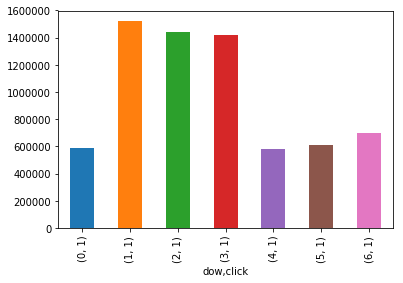

In [21]:
%matplotlib inline
data[data.click==1].groupby('dow').click.value_counts().plot(kind='bar')

From the plot, we could find the most click happens on Monday, then Tuesday and Wednesday.

In [22]:
data.nunique()

id                  40239110
click                      2
hour                     240
C1                         7
banner_pos                 7
site_id                 4737
site_domain             7745
site_category             26
app_id                  8552
app_domain               559
app_category              36
device_id            2686408
device_ip            6729486
device_model            8251
device_type                5
device_conn_type           4
C14                     2626
C15                        8
C16                        9
C17                      435
C18                        4
C19                       68
C20                      172
C21                       60
dow                        7
click_hour                24
dtype: int64

Some features have too many categories, which won't help in modeling. We also drop these columns.

In [23]:
# drop the features with too many categories
drop_list = ['id','site_id','site_domain', 'app_id','device_id', 'device_ip', 'device_model','C14','C17', 'C20']
data.drop(drop_list, axis=1, inplace=True)
test.drop(drop_list, axis=1, inplace=True)

In [24]:
# train, validation split
def split_based_hour2(data):
    """ Split data based on column hour.
    
    Use 10% of the date for validation.
    Inputs:
       data: dataframe from avazu
    Returns:
       train:
       val: 10% of the largest values of column "hour".
    """
    N = int(0.9*len(data))
    data = data.sort_values(by="hour")
    train = data[:N].copy()
    val = data[N:].copy()
    return train.reset_index(), val.reset_index()

train, val = split_based_hour2(data)

In [25]:
train.drop(train.columns[[0]],axis=1,inplace=True)
val.drop(val.columns[[0]],axis=1,inplace=True)

In [26]:
train.nunique()

click                 2
hour                218
C1                    7
banner_pos            7
site_category        26
app_domain          548
app_category         36
device_type           5
device_conn_type      4
C15                   8
C16                   9
C18                   4
C19                  66
C21                  55
dow                   7
click_hour           24
dtype: int64

## 4.2 Feature engineering

### Mean encoding

In [27]:
# do device_type mean encoding as above
mean_encoding_test(val, train) 
mean_encoding_test(test, train) 

In [28]:
# mean encoding of some other features (at least two)
# app_category encoding
mean_encoding_test(val, train, col='app_category') 
mean_encoding_test(test, train, col='app_category') 

In [29]:
# site_category encoding
mean_encoding_test(val, train, col='site_category') 
mean_encoding_test(test, train, col='site_category') 

In [30]:
# banner_pos encoding
mean_encoding_test(val, train, col='banner_pos') 
mean_encoding_test(test, train, col='banner_pos') 

In [31]:
# drop the original features
drop_list = ['device_type', 'app_category','site_category', 'banner_pos']
train.drop(drop_list, axis=1, inplace=True)
val.drop(drop_list, axis=1, inplace=True)
test.drop(drop_list, axis=1, inplace=True)

In [32]:
train.head()

,click,hour,C1,app_domain,device_conn_type,C15,C16,C18,C19,C21,dow,click_hour,device_type_mean_enc,app_category_mean_enc,site_category_mean_enc,banner_pos_mean_enc
0,0,2014-10-21,1005,7801e8d9,2,320,50,0,35,79,1,0,0.169527,0.198884,0.208541,0.164918
1,0,2014-10-21,1010,7801e8d9,0,320,50,3,35,117,1,0,0.093963,0.109662,0.127580,0.182319
2,0,2014-10-21,1005,7801e8d9,0,320,50,0,35,79,1,0,0.169527,0.198884,0.208541,0.164918
3,0,2014-10-21,1005,2347f47a,0,320,50,0,681,101,1,0,0.169527,0.109662,0.127580,0.182319
4,1,2014-10-21,1005,7801e8d9,0,320,50,0,431,117,1,0,0.169527,0.198884,0.281221,0.164918


In [33]:
val['dow'].value_counts()

3    4042897
Name: dow, dtype: int64

In [34]:
test['dow'].value_counts()

4    4577464
Name: dow, dtype: int64

Notice there is only 1 value in `dow` column in `val` and `test`, we choose to drop this column, as well as `hour`

In [35]:
train.drop(['hour', 'dow'], axis=1, inplace=True)
val.drop(['hour', 'dow'], axis=1, inplace=True)
test.drop(['hour', 'dow'], axis=1, inplace=True)

### one-hot encoding

In [36]:
train.nunique()

click                       2
C1                          7
app_domain                548
device_conn_type            4
C15                         8
C16                         9
C18                         4
C19                        66
C21                        55
click_hour                 24
device_type_mean_enc        5
app_category_mean_enc      28
site_category_mean_enc     22
banner_pos_mean_enc         7
dtype: int64

In [37]:
val.nunique()

click                       2
C1                          7
app_domain                187
device_conn_type            4
C15                         8
C16                         9
C18                         4
C19                        48
C21                        40
click_hour                 23
device_type_mean_enc        4
app_category_mean_enc      26
site_category_mean_enc     22
banner_pos_mean_enc         7
dtype: int64

In [38]:
test.nunique()

C1                          7
app_domain                201
device_conn_type            4
C15                         8
C16                         9
C18                         4
C19                        47
C21                        39
click_hour                 24
device_type_mean_enc        4
app_category_mean_enc      26
site_category_mean_enc     22
banner_pos_mean_enc         6
dtype: int64

In [39]:
train['C1'].value_counts()

1005    33326069
1002     2047224
1010      861051
1012      103691
1007       33059
1001        9248
1008        5728
Name: C1, dtype: int64

In [40]:
train['device_conn_type'].value_counts()

0    31494952
2     2829057
3     2021697
5       40364
Name: device_conn_type, dtype: int64

In [41]:
train['C18'].value_counts()

0    15112756
3    12278647
2     6337909
1     2656758
Name: C18, dtype: int64

By looking through these variables, we could found `C1`, `C18` and `device_conn_type`  have same categories in `train`, `test` and `val` dataset. Also, the number of category is not too large. Then, we could do one-hot encoding on these three features.

In [42]:
c1_Dummies = pd.get_dummies(train['C1'], prefix= 'C1', drop_first=True)
train_new = pd.concat([train, c1_Dummies], axis=1)
c1_Dummies = pd.get_dummies(val['C1'], prefix= 'C1', drop_first=True)
val_new = pd.concat([val, c1_Dummies], axis=1)
c1_Dummies = pd.get_dummies(test['C1'], prefix= 'C1', drop_first=True)
test_new = pd.concat([test, c1_Dummies], axis=1)

In [43]:
dc_Dummies = pd.get_dummies(train['device_conn_type'], prefix= 'device_conn_type', drop_first=True)
train_new = pd.concat([train_new, dc_Dummies], axis=1)
dc_Dummies = pd.get_dummies(val['device_conn_type'], prefix= 'device_conn_type', drop_first=True)
val_new = pd.concat([val_new, dc_Dummies], axis=1)
dc_Dummies = pd.get_dummies(test['device_conn_type'], prefix= 'device_conn_type', drop_first=True)
test_new = pd.concat([test_new, dc_Dummies], axis=1)

In [44]:
c18_Dummies = pd.get_dummies(train['device_conn_type'], prefix= 'device_conn_type', drop_first=True)
train_new = pd.concat([train_new, c18_Dummies], axis=1)
c18_Dummies = pd.get_dummies(val['device_conn_type'], prefix= 'device_conn_type', drop_first=True)
val_new = pd.concat([val_new, c18_Dummies], axis=1)
c18_Dummies = pd.get_dummies(test['device_conn_type'], prefix= 'device_conn_type', drop_first=True)
test_new = pd.concat([test_new, c18_Dummies], axis=1)

In [45]:
train_new.drop(['device_conn_type','C1','C18'], axis=1, inplace=True)
val_new.drop(['device_conn_type','C1','C18'], axis=1, inplace=True)
test_new.drop(['device_conn_type','C1','C18'], axis=1, inplace=True)

In [46]:
train_new.head()

,click,app_domain,C15,C16,C19,C21,click_hour,device_type_mean_enc,app_category_mean_enc,site_category_mean_enc,...,C1_1007,C1_1008,C1_1010,C1_1012,device_conn_type_2,device_conn_type_3,device_conn_type_5,device_conn_type_2,device_conn_type_3,device_conn_type_5
0,0,7801e8d9,320,50,35,79,0,0.169527,0.198884,0.208541,...,0,0,0,0,1,0,0,1,0,0
1,0,7801e8d9,320,50,35,117,0,0.093963,0.109662,0.127580,...,0,0,1,0,0,0,0,0,0,0
2,0,7801e8d9,320,50,35,79,0,0.169527,0.198884,0.208541,...,0,0,0,0,0,0,0,0,0,0
3,0,2347f47a,320,50,681,101,0,0.169527,0.109662,0.127580,...,0,0,0,0,0,0,0,0,0,0
4,1,7801e8d9,320,50,431,117,0,0.169527,0.198884,0.281221,...,0,0,0,0,0,0,0,0,0,0


### Label encoding

For the rest categorical data, we could do label encoding on it.  

In [47]:
y_train = train_new['click']
X_train = train_new.drop(['click'], axis=1)
y_val = val_new['click']
X_val = val_new.drop(['click'], axis=1)

To ensure the new category in `val` and `test` could also be encoded, we should get a full datarame which conclude all different categories in each dataset.

In [48]:
from sklearn.preprocessing import LabelEncoder
col_category = list(X_train.columns)[:6]
df = X_train.append(X_val)
df = df.append(test_new)
for col in col_category :
    encoder = LabelEncoder()
    encoder.fit(df[col])
    X_train[col] = encoder.transform(X_train[col])
    X_val[col] =encoder.transform(X_val[col])
    test_new[col] =encoder.transform(test_new[col])

/Users/minchenwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/minchenwang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [49]:
X_val.head()

,app_domain,C15,C16,C19,C21,click_hour,device_type_mean_enc,app_category_mean_enc,site_category_mean_enc,banner_pos_mean_enc,...,C1_1007,C1_1008,C1_1010,C1_1012,device_conn_type_2,device_conn_type_3,device_conn_type_5,device_conn_type_2,device_conn_type_3,device_conn_type_5
0,265,3,2,14,6,1,0.169527,0.198884,0.179566,0.182319,...,0,0,0,0,0,0,0,0,0,0
1,76,3,2,8,6,1,0.169527,0.229264,0.127580,0.164918,...,0,0,0,0,0,0,0,0,0,0
2,425,3,2,8,6,1,0.169527,0.095979,0.127580,0.164918,...,0,0,0,0,0,0,0,0,0,0
3,265,3,2,17,15,1,0.210108,0.198884,0.127580,0.164918,...,0,0,0,0,0,0,0,0,0,0
4,265,3,2,4,7,1,0.169527,0.198884,0.179566,0.182319,...,0,0,0,0,0,0,0,0,0,0


In [50]:
# let's look at the target variable
y_train.value_counts()

0    30199732
1     6186338
Name: click, dtype: int64

In [51]:
30199732/6186338

4.881681537607547

The ratio of click vs. no-click in `train` dataset is about 4.88:1. The dataset is imbalanced.

## 4.3 Fit the model

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

/Users/minchenwang/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Do the hyperparameter tunning using validation set

### Model 1

In [53]:
rf1 = RandomForestClassifier(n_estimators=10, max_depth=10, max_features=10,
                            oob_score=False, n_jobs=-1,verbose=2)
rf1.fit(X_train, y_train)

building tree 1 of 10building tree 2 of 10building tree 3 of 10
building tree 4 of 10


building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  8.6min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False)

In [54]:
y_train_pro_rf1 = rf1.predict_proba(X_train)
loss_train_rf1 = log_loss(y_train, y_train_pro_rf1)
y_val_pro_rf1 = rf1.predict_proba(X_val)
loss_val_rf1 = log_loss(y_val,y_val_pro_rf1)

[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   24.5s finished
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    2.1s finished


In [55]:
print('Model1: The logloss of the train dataset is %.3f' %loss_train_rf1)
print('Model1: The logloss of the validation(test) dataset is %.3f' %loss_val_rf1)

Model1: The logloss of the train dataset is 0.417
Model1: The logloss of the validation(test) dataset is 0.425


### Model 2

In [56]:
rf2 = RandomForestClassifier(n_estimators=20, max_depth=10, max_features=10,
                            oob_score=False, n_jobs=-1,verbose=2)
rf2.fit(X_train, y_train)

building tree 1 of 20building tree 2 of 20building tree 3 of 20
building tree 4 of 20


building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 15.9min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False)

In [57]:
y_train_pro_rf2 = rf2.predict_proba(X_train)
loss_train_rf2 = log_loss(y_train, y_train_pro_rf2)
y_val_pro_rf2 = rf2.predict_proba(X_val)
loss_val_rf2 = log_loss(y_val,y_val_pro_rf2)

[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   44.1s finished
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    4.2s finished


In [58]:
print('Model2: The logloss of the train dataset is %.3f' %loss_train_rf2)
print('Model2: The logloss of the validation(test) dataset is %.3f' %loss_val_rf2)

Model2: The logloss of the train dataset is 0.416
Model2: The logloss of the validation(test) dataset is 0.423


### Model 3

In [60]:
rf3 = RandomForestClassifier(n_estimators=20, max_depth=15, max_features=15,
                            oob_score=False, n_jobs=-1,verbose=2)
rf3.fit(X_train, y_train)

building tree 1 of 20building tree 2 of 20building tree 3 of 20building tree 4 of 20



building tree 5 of 20
building tree 6 of 20
building tree 7 of 20
building tree 8 of 20
building tree 9 of 20
building tree 10 of 20
building tree 11 of 20
building tree 12 of 20
building tree 13 of 20
building tree 14 of 20
building tree 15 of 20
building tree 16 of 20
building tree 17 of 20
building tree 18 of 20
building tree 19 of 20
building tree 20 of 20


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed: 22.1min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=None, verbose=2,
            warm_start=False)

In [61]:
y_train_pro_rf3 = rf3.predict_proba(X_train)
loss_train_rf3 = log_loss(y_train, y_train_pro_rf3)
y_val_pro_rf3 = rf2.predict_proba(X_val)
loss_val_rf3 = log_loss(y_val,y_val_pro_rf3)

[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:   46.6s finished
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    3.0s finished


In [62]:
print('Model3: The logloss of the train dataset is %.3f' %loss_train_rf3)
print('Model3: The logloss of the validation(test) dataset is %.3f' %loss_val_rf3)

Model3: The logloss of the train dataset is 0.411
Model3: The logloss of the validation(test) dataset is 0.423


As for above models, I tuned `n_estimators`, `max_depth` and `max_features` hyperparameters in RandomForestClassifier. Improving `n_estimators` from 10 to 20 could decrease logloss of the train dataset and validation set, while when keeping the `n_estimators` the same, improving `max_depth` and `max_features` from 10 to 15 doesn't have much effect on the improvement of model result.

### Feature importance

Based on above, model 3 fits the data best.

Let's have a look at the feature importance base on it.

Feature importance of Random Forest Model


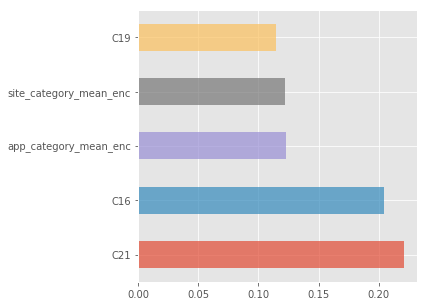

In [63]:
%matplotlib inline
import matplotlib.pyplot as plt
print('Feature importance of Random Forest Model')
plt.style.use('ggplot')
fig = plt.figure(figsize=(5, 5))
feat_importances = pd.Series(rf3.feature_importances_, index=X_train.columns)
feat_importances.nlargest(5).plot(kind='barh', alpha=0.7)
fig.savefig('rf_feature.png')

### Predict the test data

predict the test dataset

In [64]:
y_pred = rf3.predict(test_new)

[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    5.8s finished
